In [1]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Python
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

from keras.models import Model, Sequential
from keras import optimizers
from keras.layers import Input, Conv1D, Conv2D,BatchNormalization, MaxPooling1D,MaxPooling2D, LSTM, Dense, Activation, Layer,Reshape

from tensorflow.keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm_notebook as tqdm

input_duration=3
# % pylab inline

In [3]:
# Data Directory
Ravdess_paths= np.array(("drive/MyDrive/dataset-dkn/Audio_Speech_Actors_01-24/","drive/MyDrive/dataset-dkn/Audio_Song_Actors_01-24/"))
dir_list = os.listdir(Ravdess_paths[0])
dir_list.sort()
print (dir_list)

[b'Actor_01', b'Actor_02', b'Actor_03', b'Actor_04', b'Actor_05', b'Actor_06', b'Actor_07', b'Actor_08', b'Actor_09', b'Actor_10', b'Actor_11', b'Actor_12', b'Actor_13', b'Actor_14', b'Actor_15', b'Actor_16', b'Actor_17', b'Actor_18', b'Actor_19', b'Actor_20', b'Actor_21', b'Actor_22', b'Actor_23', b'Actor_24']


In [4]:
# Create DataFrame for Data intel
ravdess_db = pd.DataFrame(columns=['path','source','actor', 'gender', 'emotion','emotion_lb'])
count = 0
for data_path in Ravdess_paths:
    dir_list = os.listdir(data_path)
    dir_list.sort()
    for i in dir_list:
        file_list = os.listdir(data_path + i.decode('utf-8'))
        for f in file_list:
            nm = f.split('.')[0].split('-')
            path = data_path + i.decode('utf-8') + '/' + f
            src = int(nm[1])
            actor = int(nm[-1])
            emotion = int(nm[2])
            source = "Ravdess"

            if int(actor)%2 == 0:
                gender = "female"
            else:
                gender = "male"

            if nm[3] == '01':
                intensity = 0
            else:
                intensity = 1

            if nm[4] == '01':
                statement = 0
            else:
                statement = 1

            if nm[5] == '01':
                repeat = 0
            else:
                repeat = 1

            if emotion == 1:
                lb = "neutral"
            elif emotion == 2:
                lb = "calm"
            elif emotion == 3:
                lb = "happy"
            elif emotion == 4:
                lb = "sad"
            elif emotion == 5:
                lb = "angry"
            elif emotion == 6:
                lb = "fearful"
            elif emotion == 7:
                lb = "disgust"
            elif emotion == 8:
                lb = "surprised"
            else:
                lb = "none"

            ravdess_db.loc[count] = [path,source,actor, gender, emotion,lb]
            count += 1

In [5]:
ravdess_db.head()

,path,source,actor,gender,emotion,emotion_lb
0,drive/MyDrive/dataset-dkn/Audio_Speech_Actors_...,Ravdess,1,male,1,neutral
1,drive/MyDrive/dataset-dkn/Audio_Speech_Actors_...,Ravdess,1,male,1,neutral
2,drive/MyDrive/dataset-dkn/Audio_Speech_Actors_...,Ravdess,1,male,2,calm
3,drive/MyDrive/dataset-dkn/Audio_Speech_Actors_...,Ravdess,1,male,2,calm
4,drive/MyDrive/dataset-dkn/Audio_Speech_Actors_...,Ravdess,1,male,1,neutral


In [6]:
ravdess_db.to_csv("drive/MyDrive/RAVDESS/model/list4_4a.csv")

In [7]:
ravdess_db['split'] =  np.where((ravdess_db.actor ==23) | (ravdess_db.actor ==24), 'Test', 
                                (np.where((ravdess_db.actor ==21) | (ravdess_db.actor ==22),'Val','Train')))

In [8]:
ravdess_db['split'].value_counts()

Train    2036
Val       208
Test      208
Name: split, dtype: int64

In [9]:
ravdess_db.drop(ravdess_db.index[ravdess_db['emotion_lb'] == 'surprised'], inplace = True)
ravdess_db.loc[ravdess_db.emotion_lb=='calm',['emotion','emotion_lb']]= 1,'neutral'

In [10]:
ravdess_db.emotion_lb.value_counts()

neutral    564
happy      376
sad        376
angry      376
fearful    376
disgust    192
Name: emotion_lb, dtype: int64

In [11]:
dataset_db = ravdess_db.copy()

In [12]:
dataset_db.emotion_lb = dataset_db.gender+"_"+dataset_db.emotion_lb

In [13]:
dataset_db.index=range(len(dataset_db.index))

In [14]:
dataset_db.to_csv("drive/MyDrive/RAVDESS/model/list2_4_4a.csv")


In [15]:
dataset_db.emotion_lb.value_counts()
dataset_db.sort_values(by=['path'], inplace=True)
dataset_db.head()

,path,source,actor,gender,emotion,emotion_lb,split
1252,drive/MyDrive/dataset-dkn/Audio_Song_Actors_01...,Ravdess,1,male,1,male_neutral,Train
1249,drive/MyDrive/dataset-dkn/Audio_Song_Actors_01...,Ravdess,1,male,1,male_neutral,Train
1248,drive/MyDrive/dataset-dkn/Audio_Song_Actors_01...,Ravdess,1,male,1,male_neutral,Train
1251,drive/MyDrive/dataset-dkn/Audio_Song_Actors_01...,Ravdess,1,male,1,male_neutral,Train
1258,drive/MyDrive/dataset-dkn/Audio_Song_Actors_01...,Ravdess,1,male,1,male_neutral,Train


In [16]:
dataset_db.index = range(len(dataset_db.index))

In [17]:
dataset_db.shape

(2260, 7)

In [18]:
import h5py
with h5py.File('drive/MyDrive/RAVDESS/model/Ravdess_audio_Mel_spec.h5', 'r') as hf:
  audios = hf['Ravdess_audio_Mel_spec'][:]

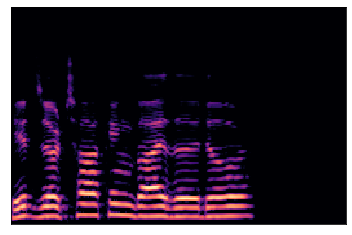

In [19]:
librosa.display.specshow(audios[0].reshape(128,259))

In [20]:
x_train = audios[(dataset_db['split'] == 'Train')]
y_train = dataset_db.emotion_lb[(dataset_db['split'] == 'Train')]

print(x_train.shape,y_train.shape)

(1876, 128, 259, 1) (1876,)


In [21]:
x_test = audios[(dataset_db['split'] == 'Val')]
y_test = dataset_db.emotion_lb[(dataset_db['split'] == 'Val')]

print(x_test.shape,y_test.shape)

(192, 128, 259, 1) (192,)


In [22]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [23]:
x_traincnn = x_train
x_testcnn = x_test

In [24]:
x_traincnn.shape,x_testcnn.shape,y_train.shape,y_test.shape

((1876, 128, 259, 1), (192, 128, 259, 1), (1876, 12), (192, 12))

In [25]:
# CNN I/P Config
num_classes = len(np.unique(np.argmax(y_train, 1)))
input_shape = x_traincnn.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [26]:
input_shape

(128, 259, 1)

In [27]:
import tensorflow as tf 
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=256,kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())
# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = tf.optimizers.Adamax(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [28]:
model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 259, 256)     2560      
                                                                 
 batch_normalization (BatchN  (None, 128, 259, 256)    1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 259, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 129, 256)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 129, 256)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 129, 256)     

In [29]:
#Train Config

batch_size = 16
num_epochs = 100

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('drive/MyDrive/RAVDESS/model/Audio_2DCNN_4L_R2_adamax_relu_lr0001.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/100
118/118 [==============================] - 29s 138ms/step - loss: 3.4362 - categorical_accuracy: 0.1402 - val_loss: 2.2868 - val_categorical_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 2/100
118/118 [==============================] - 16s 132ms/step - loss: 3.0159 - categorical_accuracy: 0.1498 - val_loss: 2.3386 - val_categorical_accuracy: 0.0885 - lr: 1.0000e-04
Epoch 3/100
118/118 [==============================] - 16s 134ms/step - loss: 2.8606 - categorical_accuracy: 0.1674 - val_loss: 2.3680 - val_categorical_accuracy: 0.1354 - lr: 1.0000e-04
Epoch 4/100
118/118 [==============================] - 16s 133ms/step - loss: 2.7700 - categorical_accuracy: 0.1887 - val_loss: 2.3556 - val_categorical_accuracy: 0.1302 - lr: 1.0000e-04
Epoch 5/100
118/118 [==============================] - 16s 134ms/step - loss: 2.6818 - categorical_accuracy: 0.1780 - val_loss: 2.3318 - val_categorical_accuracy: 0.1615 - lr: 1.0000e-04
Epoch 6/100
118/118 [==============================] - 16s 135ms/

In [30]:
max(cnnhistory.history['val_categorical_accuracy'])

0.4895833432674408

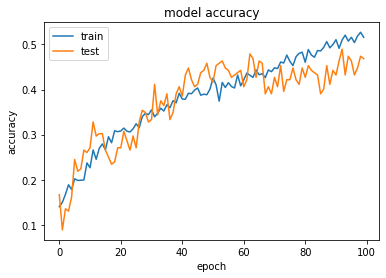

In [31]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['categorical_accuracy'])
plt.plot(cnnhistory.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

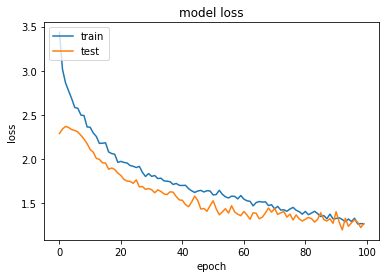

In [32]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
# Saving the model.json

import json
model_json = model.to_json()
with open("drive/MyDrive/RAVDESS/model/Audio_2DCNN_4L_R2_adamax_relu_lr0001.json", "w") as json_file:
    json_file.write(model_json)

In [34]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('drive/MyDrive/RAVDESS/model/Audio_2DCNN_4L_R2_adamax_relu_lr0001.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [35]:
from keras.models import load_model

# Returns a compiled model identical to the previous one
loaded_model.load_weights('drive/MyDrive/RAVDESS/model/Audio_2DCNN_4L_R2_adamax_relu_lr0001.h5')

In [36]:
new_model = load_model('drive/MyDrive/RAVDESS/model/Audio_2DCNN_4L_R2_adamax_relu_lr0001.h5')

In [37]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 48.96%


In [38]:
x_test_data = audios[(dataset_db['split'] == 'Test')]
y_test_data = dataset_db.emotion_lb[(dataset_db['split'] == 'Test')]

print(x_test_data.shape,y_test_data.shape)

(192, 128, 259, 1) (192,)


In [39]:
preds = loaded_model.predict(x_test_data,batch_size=16,verbose=1)
preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))

12/12 [==============================] - 1s 37ms/step


In [40]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_neutral
1,male_neutral
2,male_neutral
3,male_neutral
4,male_neutral
5,male_neutral
6,male_neutral
7,male_neutral
8,male_neutral
9,male_neutral


In [41]:
actualdf = pd.DataFrame({'actualvalues': y_test_data})
actualdf[:10]
actualdf.index = range(len(actualdf.index))

In [42]:
finaldf = pd.concat([actualdf,preddf],axis=1)
finaldf.head()

,actualvalues,predictedvalues
0,male_neutral,male_neutral
1,male_neutral,male_neutral
2,male_neutral,male_neutral
3,male_neutral,male_neutral
4,male_neutral,male_neutral


In [43]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,6), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

47.39583333333333

In [45]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

41.85326531041156

In [46]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[12,  0,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  0, 11,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 3,  3,  5,  1,  2,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 16,  7,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  1,  8,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 11,  0,  5,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  6,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  7,  0,  7,  2,  0,  0],
       [ 1,  0,  2,  0,  0,  0,  4,  0,  5,  3,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  9,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  4,  3,  0,  9,  0]])

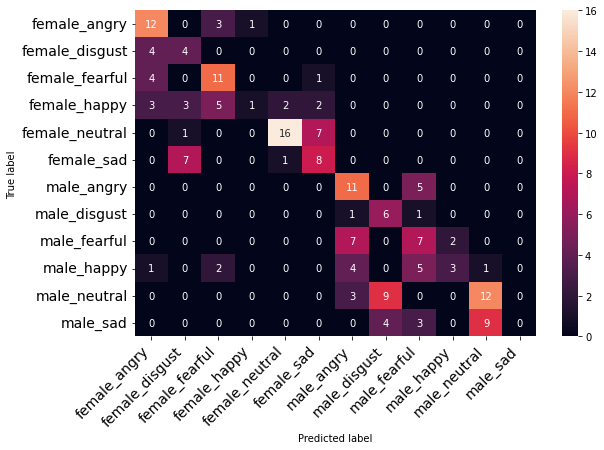

In [47]:
class_names=sorted(set(finaldf.actualvalues))
print_confusion_matrix(c, class_names)